In [1]:
import os
import pandas as pd

In [14]:
df = pd.read_csv('../results/cut_segments_pulp_fiction.csv').drop(['Unnamed: 0'], axis=1, errors='ignore')
# df['input_path'] = df['input_path'].apply(lambda x: "convert_preprocessed/" + x.replace('/','_'))
df['input_path'] = df['input_path'].apply(lambda x: "../" + x)
df.rename(columns={'input_path': 'file_mapper_paths'}, inplace=True)
df.head()

,speaker,id,duration,text,seg,start,end,start_tt,end_tt,file_mapper_paths
0,Pumpkin,1,4,Forget it . It 's too risky . I 'm through doi...,"00:00:26,950 --> 00:00:30,878","00:00:26,950","00:00:30,878",26.950,30.878,../cut_preprocessed/audio_track_pulp_fiction_e...
1,Honey Bunny,2,3,You always say that . The same thing every time .,"00:00:30,946 --> 00:00:34,263","00:00:30,946","00:00:34,263",30.946,34.263,../cut_preprocessed/audio_track_pulp_fiction_e...
2,Honey Bunny,3,2,"`` I 'm through , never again , too dangerous ...","00:00:34,260 --> 00:00:36,254","00:00:34,260","00:00:36,254",34.260,36.254,../cut_preprocessed/audio_track_pulp_fiction_e...
3,Pumpkin,4,2,I know that 's what I always say . I 'm always...,"00:00:36,253 --> 00:00:38,716","00:00:36,253","00:00:38,716",36.253,38.716,../cut_preprocessed/audio_track_pulp_fiction_e...
4,Honey Bunny,5,3,You forget about it in a day or two .,"00:00:38,715 --> 00:00:42,043","00:00:38,715","00:00:42,043",38.715,42.043,../cut_preprocessed/audio_track_pulp_fiction_e...


In [3]:
import logging
from vanpy.utils.utils import load_config

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s:%(name)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

config = load_config('configs/pulp_fiction_pipeline.yaml')

In [6]:
from vanpy.core.Pipeline import Pipeline
pipeline = Pipeline(
         ['file_mapper', 'pyannote_sd', 'librosa_features_extractor', 'speechbrain_embedding', 'openai_whisper_stt', 'speech_brain_iemocap_emotion',
         'vanpy_gender', 'vanpy_age', 'vanpy_height', 'vanpy_emotion', 'wav2vec2adv', 'yamnet_classifier', 'cosine_distance_diarization', 'agglomerative_clustering_diarization', 'gmm_clustering_diarization'], config=config)

2024-11-06 13:23:54 - INFO:PreprocessPipeline - Created Preprocessing Pipeline with 2 components
2024-11-06 13:23:54 - WARNING:speechbrain.utils.torch_audio_backend - The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
2024-11-06 13:23:54 - WARNING:speechbrain.utils.torch_audio_backend - The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
2024-11-06 13:23:54 - INFO:FeatureExtractionPipeline - Created Feature Extraction Pipeline with 2 components
2024-11-06 13:23:57 - INFO:ClassificationPipeline - Created Classification Pipeline with 11 components


In [ ]:
processed_payload = pipeline.process()

In [ ]:
features_df = pd.merge(left=df[['file_mapper_paths', 'speaker', 'id', 'duration', 'text', 'start_tt', 'end_tt']], right=processed_payload.df, on='file_mapper_paths', how='inner')

In [23]:
def clean_df(df, segmentizer='silero_vad'):
    df = df[~df['text'].str.startswith('-LSB-')]
    df = df[df[f'{segmentizer}_segment_stop'] - df[f'{segmentizer}_segment_start'] > 1]
    df = df[~df['yamnet_classification'].str.startswith('Music', na=False)]
    df = df.drop_duplicates(subset='id', keep="first")
    return df

In [ ]:
segmentizers = ['silero_vad', 'pyannote_sd']
segmentizer = segmentizers[0]
features_df = clean_df(features_df, segmentizer=segmentizer)

In [43]:
features_df = pd.read_csv('results/pulp_fiction/df_pulp_fiction_full_with_annotation_SileroVAD_clean.csv')

In [49]:
calssification_columns_list = [ #f'{segmentizer}_processed_path',
 # 'pyannote_diarization_classification',
 'whisper_transcript',
 'whisper_language',
 'speech_brain_iemocap_emotion',
 'vanpy_gender_classification',
 'vanpy_age_estimation',
 'vanpy_height_estimation',
 'vanpy_emotion_classification',
 'arousal',
 'dominance',
 'valence',
 'yamnet_classification',
 'cosine_distance_diarization',
 'agglomerative_clustering_diarization',
 'gmm_clustering_diarization']

In [50]:
features_and_annotations_df_columns = calssification_columns_list  # processed_payload.get_classification_df().columns.tolist()
# features_and_annotations_df_columns.extend(['silero_vad_processed_path', 'speaker', 'id', 'duration', 'text', 'silero_vad_segment_start', 'silero_vad_segment_stop'])
features_and_annotations_df_columns.extend([f'{segmentizer}_processed_path', 'speaker', 'id', 'duration', 'text', f'{segmentizer}_segment_start', f'{segmentizer}_segment_stop'])
features_and_annotations_df = features_df[features_and_annotations_df_columns]
features_and_annotations_df = features_and_annotations_df.dropna(subset=[f'{segmentizer}_processed_path'])

In [44]:
film_final_shooting_date = '30.11.1993'
actors_df = pd.read_csv('data/Pulp_Fiction_Actors.tsv', sep='\t')
actors_df['screening_age'] = actors_df['birth_date'].apply(lambda x: (pd.to_datetime(film_final_shooting_date) - pd.to_datetime(x)).days / 365)

In [45]:
actors_df

,actor,character,gender,birth_date,height,screening_age
0,Tim Roth,Pumpkin,M,14.05.1961,1.73,32.569863
1,Amanda Plummer,Honey Bunny,F,23.03.1957,1.63,36.715068
2,John Travolta,Vincent Vega,M,14.02.1954,1.88,39.819178
3,Samuel L. Jackson,Jules Winnfield,M,21.12.1948,1.89,44.972603
4,Phil LaMarr,Marvin,M,24.01.1967,1.77,26.868493
5,Frank Whaley,Brett,M,20.07.1963,1.75,30.386301
6,Burr Steers,Roger,M,08.10.1965,NaN,28.326027
7,Bruce Willis,Butch Coolidge,M,19.03.1955,1.82,38.728767
8,Ving Rhames,Marsellus Wallace,M,12.05.1959,1.80,34.010959
9,Paul Calderon,Paul,M,07.07.1959,NaN,34.424658


C:\ProgramData\miniconda3\envs\vanpy-gpu-3.9\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\miniconda3\envs\vanpy-gpu-3.9\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


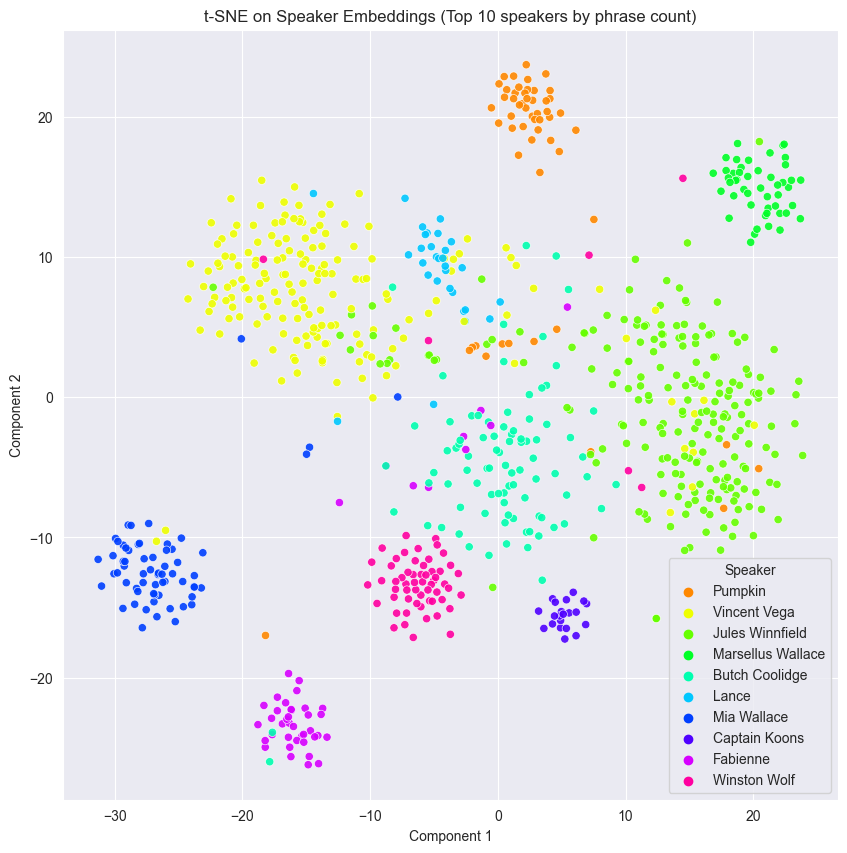

In [47]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Select the necessary columns
feature_cols = [str(i) + '_speechbrain_embedding' for i in range(192)]
features = features_df[feature_cols].dropna()

# Get the top 10 speakers by phrase count
top_speakers = features_df['speaker'].value_counts().nlargest(10).index

# Filter the features and speaker data to include only the top speakers
features_top_speakers = features[features_df['speaker'].isin(top_speakers)]
speakers_top_speakers = features_df[features_df['speaker'].isin(top_speakers)]['speaker']

# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=0)

# Fit and transform the features of the top speakers
tsne_results = tsne.fit_transform(features_top_speakers)

# Create a DataFrame to plot
tsne_df = pd.DataFrame(data = tsne_results, columns = ['Component 1', 'Component 2'])
tsne_df['Speaker'] = speakers_top_speakers.reset_index(drop=True)

# Use seaborn to visualize the result
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="Component 1", y="Component 2",
    hue="Speaker",
    palette=sns.color_palette("hsv", len(tsne_df['Speaker'].unique())),
    data=tsne_df,
    legend="full",
    alpha=0.9
)

plt.title('t-SNE on Speaker Embeddings (Top 10 speakers by phrase count)')
plt.show()

In [51]:
features_and_annotations_df['gender_value'] = features_and_annotations_df['vanpy_gender_classification'].apply(lambda x: 1 if x == 'male' else 0)

In [52]:
mean_estimation_df = features_and_annotations_df[['speaker', 'gender_value', 'vanpy_age_estimation', 'vanpy_height_estimation', 'arousal', 'dominance', 'valence']].groupby('speaker').mean()

In [53]:
mean_estimation_df

,gender_value,vanpy_age_estimation,vanpy_height_estimation,arousal,dominance,valence
speaker,,,,,,
Brett,1.000000,39.597449,176.114030,0.539209,0.579956,0.486682
Buddy Holly,1.000000,42.280646,181.054893,0.609782,0.629878,0.664443
Butch Coolidge,0.965909,42.465011,181.316488,0.547484,0.566747,0.438307
Butch's Mother,0.000000,42.051873,173.056470,0.579959,0.606939,0.532456
Captain Koons,1.000000,46.178748,181.497304,0.401673,0.503533,0.455574
Ed Sullivan,1.000000,55.349458,180.785845,0.680864,0.670596,0.602886
Esmarelda Villalobos,0.000000,47.604307,174.872878,0.392848,0.426642,0.429301
Fabienne,0.173913,41.725370,173.200753,0.465586,0.502330,0.523977
Honey Bunny,0.333333,42.444041,176.288420,0.592674,0.600231,0.444772


In [54]:
merged_df = pd.merge(left=actors_df, right=mean_estimation_df, left_on='character', right_on='speaker', how='inner')
merged_df['height'] = merged_df['height'].apply(lambda x: x * 100)
merged_df['gender_confidence'] = merged_df.apply(lambda x: x['gender_value'] if x['gender'] == "M" else 1 - x['gender_value'], axis=1)

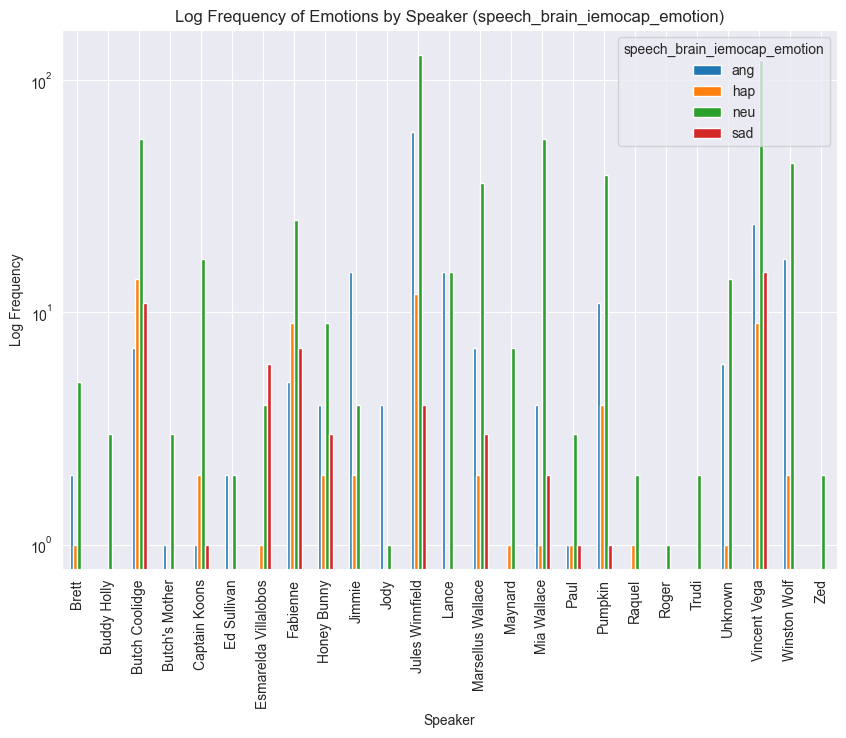

In [55]:
from matplotlib import pyplot as plt

# Create a cross-tabulation of 'speaker' and 'vanpy_ravdess_emotion'
emotion_by_speaker = pd.crosstab(features_and_annotations_df['speaker'], features_and_annotations_df['speech_brain_iemocap_emotion'])

# Plot the grouped bar chart
emotion_by_speaker.plot(kind='bar', stacked=False, figsize=(10, 7))

# Add labels and title
plt.xlabel('Speaker')
plt.ylabel('Log Frequency')
plt.title('Log Frequency of Emotions by Speaker (speech_brain_iemocap_emotion)')

# Set y-axis to log scale
plt.yscale('log')

plt.show()

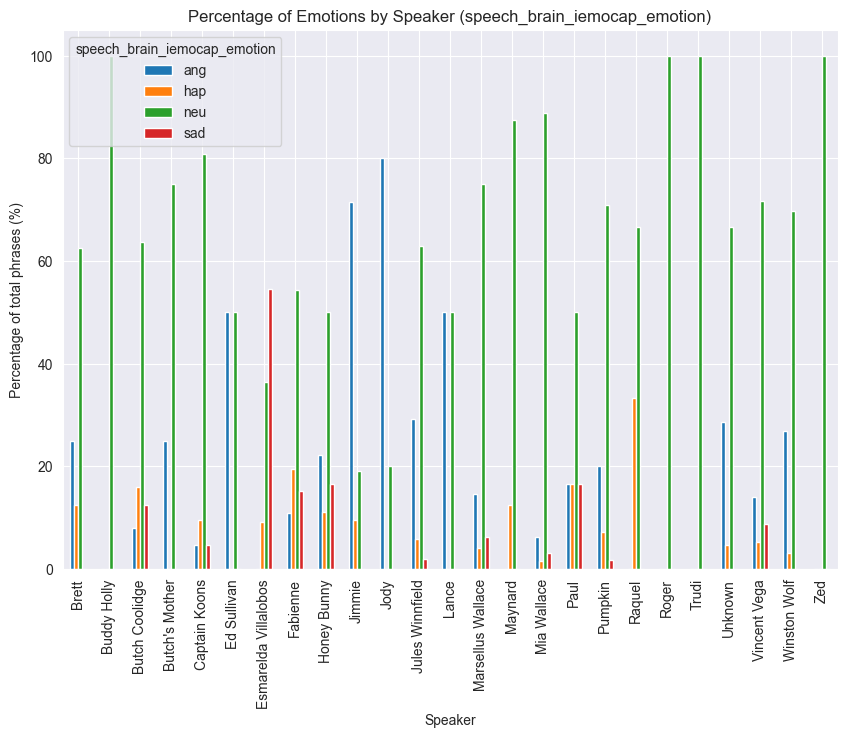

In [56]:
import numpy as np

# Create a cross-tabulation of 'speaker' and 'vanpy_ravdess_emotion'
emotion_by_speaker = pd.crosstab(features_and_annotations_df['speaker'], features_and_annotations_df['speech_brain_iemocap_emotion'])

# Normalize each row (speaker) to sum to 1 (proportion of total phrases)
emotion_by_speaker = emotion_by_speaker.div(emotion_by_speaker.sum(axis=1), axis=0)

# Convert to percentages
emotion_by_speaker = emotion_by_speaker.mul(100)

# Plot the grouped bar chart
emotion_by_speaker.plot(kind='bar', stacked=False, figsize=(10, 7))

# Add labels and title
plt.xlabel('Speaker')
plt.ylabel('Percentage of total phrases (%)')
plt.title('Percentage of Emotions by Speaker (speech_brain_iemocap_emotion)')

plt.show()

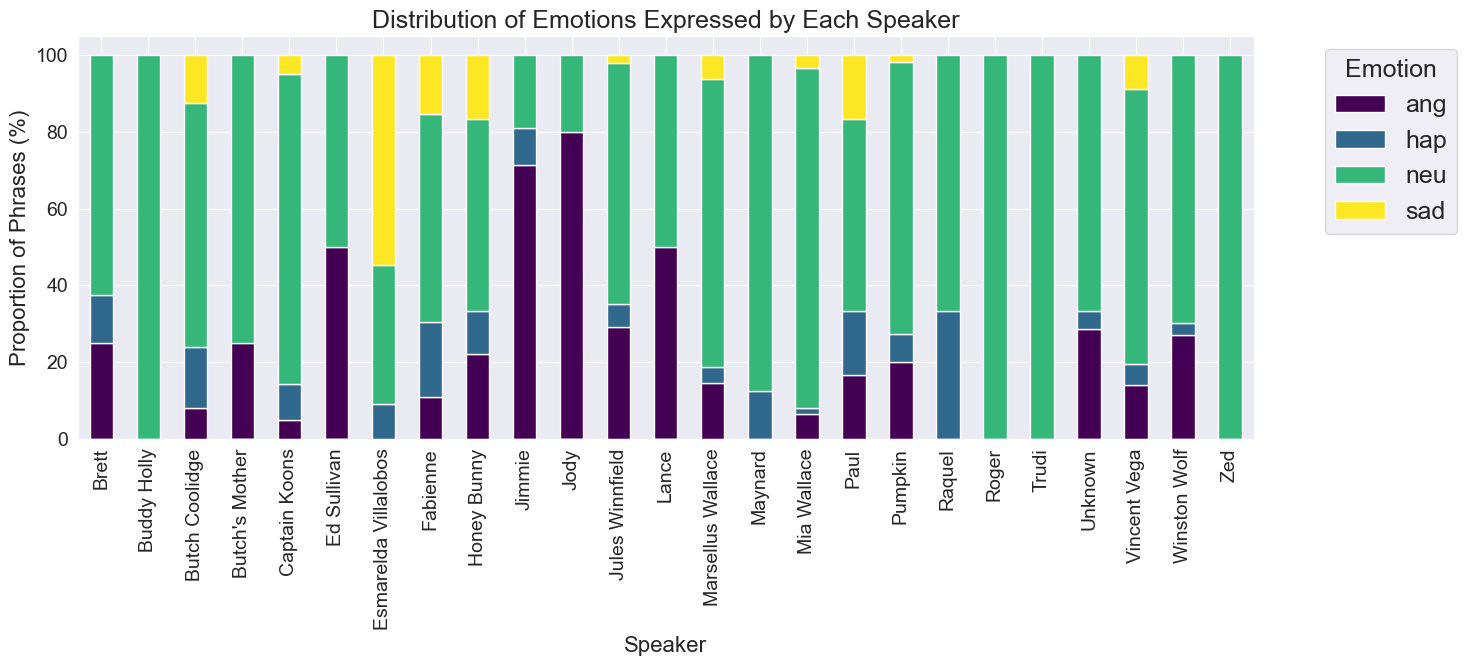

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 18, 'axes.titlesize': 18, 'axes.labelsize': 16, 'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.fontsize': 18})

# Create a cross-tabulation of 'speaker' and 'speech_brain_iemocap_emotion'
emotion_by_speaker = pd.crosstab(features_and_annotations_df['speaker'], features_and_annotations_df['speech_brain_iemocap_emotion'])

# Normalize each row (speaker) to sum to 1 (proportion of total phrases)
emotion_by_speaker = emotion_by_speaker.div(emotion_by_speaker.sum(axis=1), axis=0)

# Convert to percentages
emotion_by_speaker = emotion_by_speaker.mul(100)

# Plot the stacked bar chart
ax = emotion_by_speaker.plot(kind='bar', stacked=True, figsize=(15, 7), colormap='viridis')

# Add labels and title
plt.xlabel('Speaker')
plt.ylabel('Proportion of Phrases (%)')
plt.title('Distribution of Emotions Expressed by Each Speaker')

# Add legend and adjust its location
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

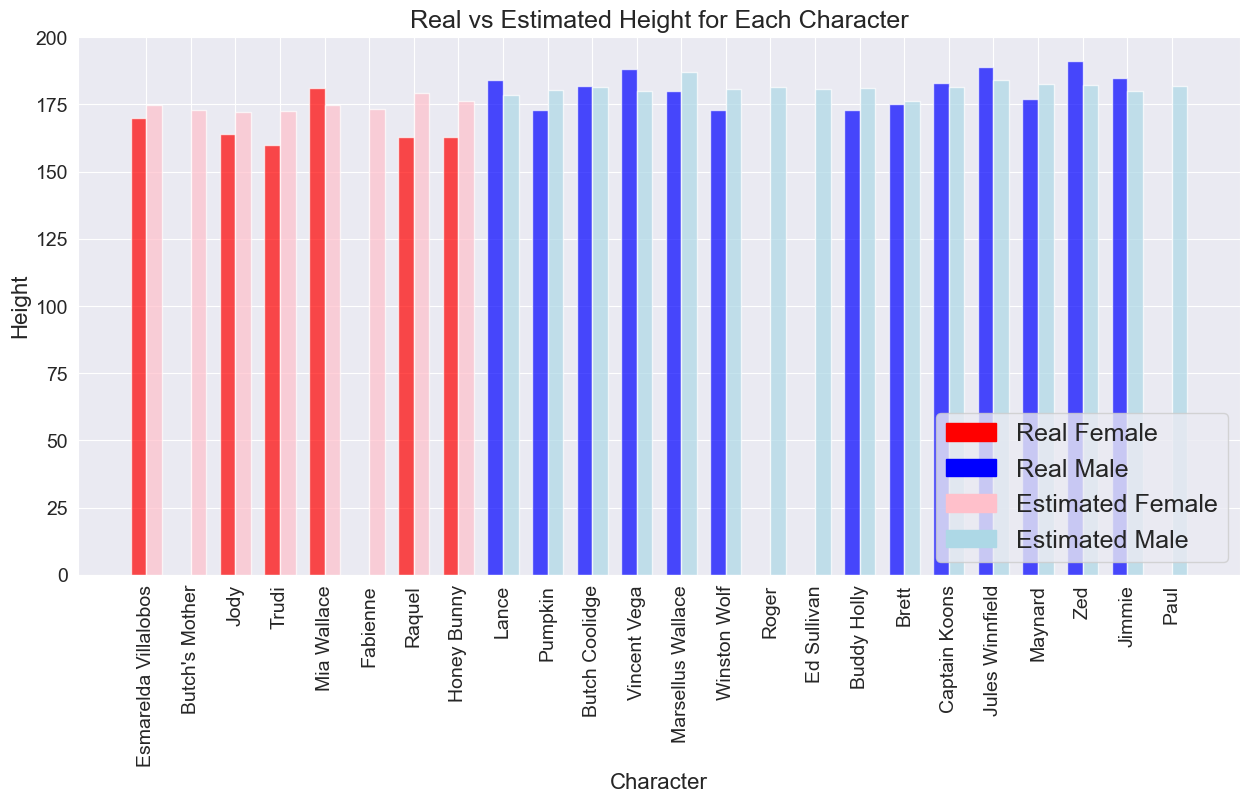

In [58]:
# plot real height distribution vs vanpy height estimation distribution grouped by gender
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

plt.rcParams.update({'font.size': 18, 'axes.titlesize': 18, 'axes.labelsize': 16, 'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.fontsize': 18})

# Sort by gender_value
sorted_df = merged_df.sort_values('gender_value')

# Set colors based on gender
colors = ['red' if g == 'F' else 'blue' for g in sorted_df['gender']]
light_colors = ['pink' if g == 'F' else 'lightblue' for g in sorted_df['gender']]  # light red and light blue

# Create an index for each character
ind = np.arange(len(sorted_df))

# Create the bar plot
plt.figure(figsize=(15, 7))  # Adjust size as needed
width = 0.35  # width of the bars

# Plot the real heights
plt.bar(ind - width/2, sorted_df['height'], width, color=colors, alpha=0.7, label='Real')

# Plot the estimated heights
plt.bar(ind + width/2, sorted_df['vanpy_height_estimation'], width, color=light_colors, alpha=0.7, label='Estimated')

# Label axes and title
plt.xlabel('Character')
plt.ylabel('Height')
plt.title('Real vs Estimated Height for Each Character')

# Rotate x labels if needed and set them to character names
plt.xticks(ind, sorted_df['character'], rotation=90)

# Create legend
red_patch = mpatches.Patch(color='red', label='Real Female')
blue_patch = mpatches.Patch(color='blue', label='Real Male')
light_red_patch = mpatches.Patch(color='pink', label='Estimated Female')
light_blue_patch = mpatches.Patch(color='lightblue', label='Estimated Male')

plt.legend(handles=[red_patch, blue_patch, light_red_patch, light_blue_patch], loc='lower right')

# Show the plot
plt.show()

In [104]:
sorted_df

,actor,character,gender,birth_date,height,screening_age,gender_value,vanpy_age_estimation,vanpy_height_estimation,arousal,dominance,valence,gender_confidence
17,Angela Jones,Esmarelda Villalobos,F,23.12.1968,170.0,24.953425,0.000000,47.604307,174.872878,0.392848,0.426642,0.429301,1.000000
15,Brenda Hillhouse,Butch's Mother,F,11.12.1953,NaN,40.076712,0.000000,42.051873,173.056470,0.579959,0.606939,0.532456,1.000000
10,Rosanna Arquette,Jody,F,10.08.1959,164.0,34.169863,0.000000,33.376050,172.048386,0.833691,0.778168,0.421204,1.000000
9,Bronagh Gallagher,Trudi,F,26.04.1972,160.0,21.610959,0.000000,37.321129,172.533957,0.527602,0.547970,0.479292,1.000000
12,Uma Thurman,Mia Wallace,F,29.04.1970,181.0,23.605479,0.031746,38.576639,174.744001,0.478497,0.542659,0.433414,0.968254
18,Maria de Medeiros,Fabienne,F,19.08.1965,NaN,28.301370,0.173913,41.725370,173.200753,0.465586,0.502330,0.523977,0.826087
23,Julia Sweeney,Raquel,F,10.10.1959,163.0,34.164384,0.333333,38.104133,179.349817,0.591782,0.602941,0.607744,0.666667
1,Amanda Plummer,Honey Bunny,F,23.03.1957,163.0,36.715068,0.333333,42.444041,176.288420,0.592674,0.600231,0.444772,0.666667
11,Eric Stoltz,Lance,M,30.09.1961,184.0,32.189041,0.900000,38.694676,178.511359,0.725696,0.704992,0.329051,0.900000
0,Tim Roth,Pumpkin,M,14.05.1961,173.0,32.569863,0.927273,35.900812,180.520069,0.649285,0.659060,0.375133,0.927273


In [112]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

# For males
male_df = sorted_df[sorted_df['gender'] == 'M'][['height', 'vanpy_height_estimation', 'gender']].dropna()
male_real = male_df['height']
male_estimated = male_df['vanpy_height_estimation']
# rmse_male = sqrt(mean_squared_error(male_real, male_estimated))
# print(f"RMSE for males: {rmse_male}")
mse_male = mean_absolute_error(male_real, male_estimated)
print(f"MAE for males: {mse_male}")

# For females
female_df = sorted_df[sorted_df['gender'] == 'F'][['height', 'vanpy_height_estimation', 'gender']].dropna()
female_real = female_df['height']
female_estimated = female_df['vanpy_height_estimation']
# rmse_female = sqrt(mean_squared_error(female_real, female_estimated))
# print(f"RMSE for females: {rmse_female}")
mse_female = mean_absolute_error(female_real, female_estimated)
print(f"MAE for females: {mse_female}")

MAE for males: 5.522400009993034
MAE for females: 10.224909439650967


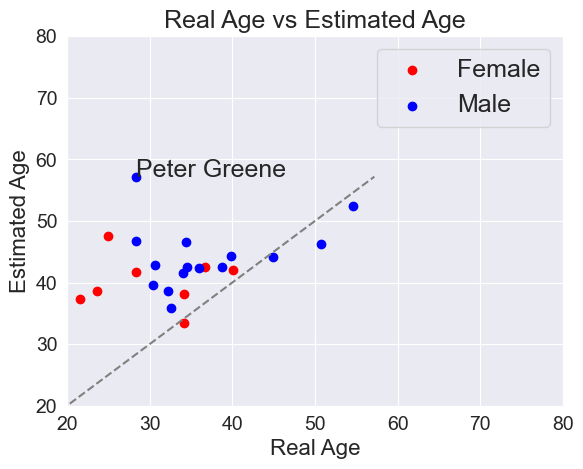

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming merged_df is your dataframe

# Separate the data for males and females
df_male = merged_df[merged_df['gender'] == 'M'].copy()
df_female = merged_df[merged_df['gender'] == 'F'].copy()

# Sort the dataframes
df_male.sort_values('screening_age', inplace=True)
df_female.sort_values('screening_age', inplace=True)

# Define outliers. Adjust this according to your definition of an "outlier"
outlier_threshold = df_male['vanpy_age_estimation'].quantile(0.95)

# Plot the data
plt.scatter(df_female['screening_age'], df_female['vanpy_age_estimation'], color='red', label='Female')
plt.scatter(df_male['screening_age'], df_male['vanpy_age_estimation'], color='blue', label='Male')

# Add labels to outliers
for i, row in df_male.iterrows():
    if row['vanpy_age_estimation'] > outlier_threshold:
        plt.text(row['screening_age'], row['vanpy_age_estimation'], row['actor'])

# Add a reference line
max_age = max(merged_df['screening_age'].max(), merged_df['vanpy_age_estimation'].max())
plt.plot([0, max_age], [0, max_age], color='gray', linestyle='--')

# Label the axes and title
plt.xlabel('Real Age')
plt.ylabel('Estimated Age')
plt.title('Real Age vs Estimated Age')

# Limit x and y ticks
plt.xlim(20, 80)
plt.ylim(20, 80)

# Show the legend
plt.legend()

# Show the plot
plt.show()

In [60]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

# For males
male_df = sorted_df[sorted_df['gender'] == 'M'][['screening_age', 'vanpy_age_estimation', 'gender']].dropna()
male_real = male_df['screening_age']
male_estimated = male_df['vanpy_age_estimation']
# rmse_male = sqrt(mean_squared_error(male_real, male_estimated))
# print(f"RMSE for males: {rmse_male}")
mse_male = mean_absolute_error(male_real, male_estimated)
print(f"MAE for males: {mse_male}")

# For females
female_df = sorted_df[sorted_df['gender'] == 'F'][['screening_age', 'vanpy_age_estimation', 'gender']].dropna()
female_real = female_df['screening_age']
female_estimated = female_df['vanpy_age_estimation']
# rmse_female = sqrt(mean_squared_error(female_real, female_estimated))
# print(f"RMSE for females: {rmse_female}")
mse_female = mean_absolute_error(female_real, female_estimated)
print(f"MAE for females: {mse_female}")

MAE for males: 8.52639862270772
MAE for females: 9.899238383386942


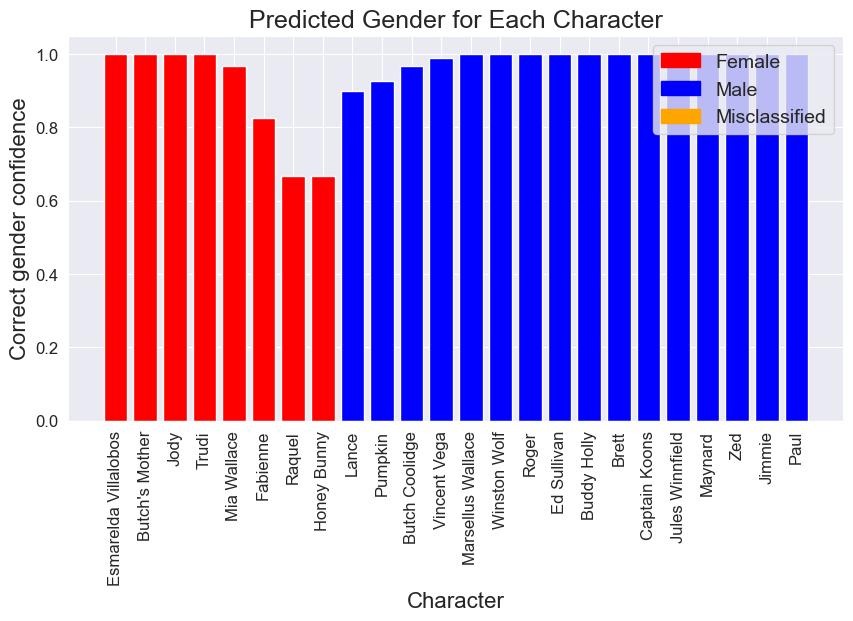

In [111]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Sort by gender_value
sorted_df = merged_df.sort_values('gender_value')

# Define a function to classify based on the threshold and real gender
def classify_gender(row):
    if row['gender_value'] >= 0.5 and row['gender'] == 'M':  # correctly classified as male
        return 'blue'
    elif row['gender_value'] < 0.5 and row['gender'] == 'F':  # correctly classified as female
        return 'red'
    else:  # misclassified
        return 'orange'

# Apply the function to create a list of colors
colors = sorted_df.apply(classify_gender, axis=1)

# Create the bar plot
plt.figure(figsize=(10, 5))  # Adjust size as needed
plt.bar(sorted_df['character'], sorted_df['gender_confidence'], color=colors)

# Label axes and title
plt.xlabel('Character')
plt.ylabel('Correct gender confidence')
plt.title('Predicted Gender for Each Character')

# Rotate x labels if needed
plt.xticks(rotation=90)

# Create legend
blue_patch = mpatches.Patch(color='blue', label='Male')
red_patch = mpatches.Patch(color='red', label='Female')
orange_patch = mpatches.Patch(color='orange', label='Misclassified')
plt.legend(handles=[red_patch, blue_patch, orange_patch])

# Show the plot
plt.show()

In [114]:
sorted_df['gender_confidence'].mean()

0.9545454737670211

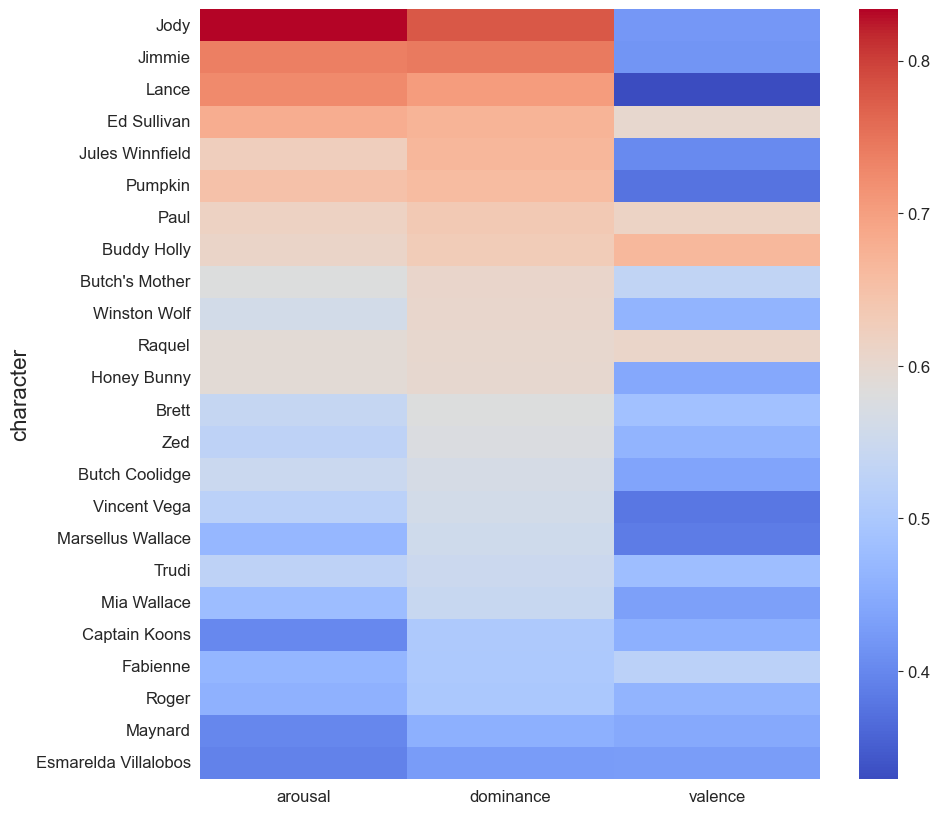

In [113]:
import seaborn as sns

# Sort in ascending order
sorted_df = merged_df.sort_values(by=['dominance', 'valence', 'arousal'], ascending=[False, False, False])
# Select relevant columns and set character as index
heatmap_data = sorted_df.set_index('character')[['arousal', 'dominance', 'valence']]

# Create the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_data, cmap='coolwarm')

plt.show()